In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53323 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:53326" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:53348, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:53345, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:53351, threads: 2>})

### Compare Model Accuracies

Let's take a look at all our models to see which one was able to achieve the best accuracy both before and after tuning.

In [4]:
#Read in all score dataframes from other notebooks
scores_list = os.listdir('DFs/scores')
score_df=pd.DataFrame()
for score in scores_list:
    df = pd.read_pickle(r'DFs/scores/{score}'.format(score=score))
    score_df = pd.concat([score_df, df], join='outer')
#score_df.index.rename('Model', inplace=True)
score_df

,model,par,MAPE,MAE,base_estimator,learning_rate,loss,n_estimators,random_state,alpha,...,verbose,average,early_stopping,epsilon,eta0,n_iter_no_change,penalty,power_t,shuffle,validation_fraction
0,ADA,40,3.778916e-01,1.079934e+00,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADA,12,4.317667e-01,1.072343e+00,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADA,28,5.092852e-01,1.055778e+00,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADA,39,6.117837e-01,1.130371e+00,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADA,37,6.833616e-01,1.167303e+00,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ADA_lr5,40,3.893954e-01,1.554368e+00,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ADA_lr5,12,3.601646e-01,1.325213e+00,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ADA_lr5,28,3.316574e-01,8.878974e-01,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ADA_lr5,39,3.827463e-01,8.761050e-01,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ADA_lr5,37,3.601066e-01,7.528592e-01,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
model_scores = score_df.groupby('model')[['MAPE', 'MAE']].mean()

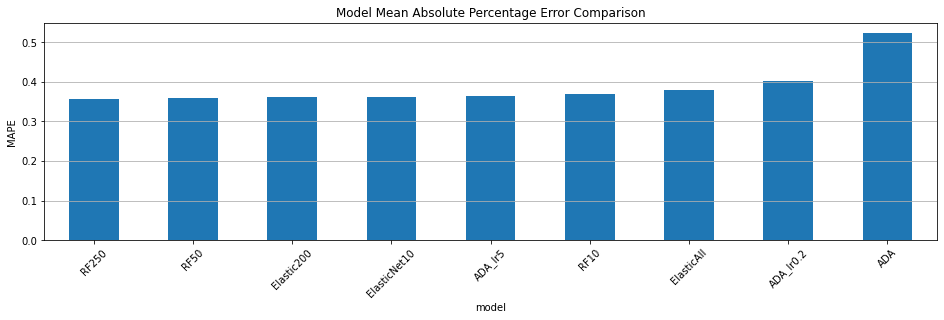

In [6]:
#Plot the accuracies from worst to best going left to right
plt.figure(figsize=(16, 6))
model_scores.drop(index='SGD').sort_values('MAPE')['MAPE'].plot(kind='bar', figsize=(16, 4))
plt.ylabel('MAPE')
plt.title('Model Mean Absolute Percentage Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

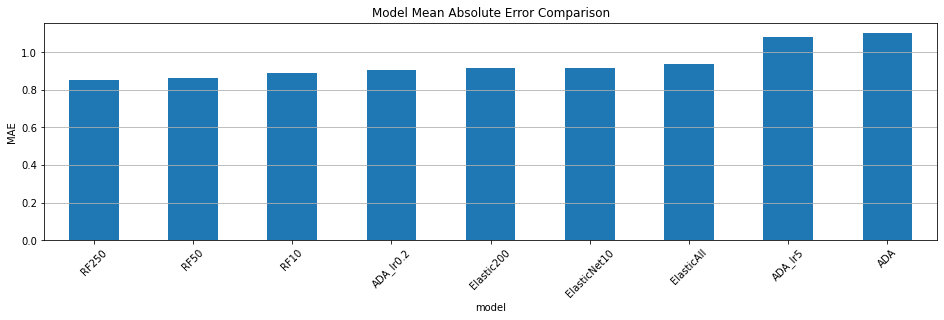

In [7]:
#Plot the accuracies from worst to best going left to right
plt.figure(figsize=(16, 6))
model_scores.drop(index='SGD').sort_values('MAE')['MAE'].plot(kind='bar', figsize=(16, 4))
plt.ylabel('MAE')
plt.title('Model Mean Absolute Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

In [8]:
model_scores_min = score_df.groupby('model')[['MAPE', 'MAE']].min()
model_scores_max = score_df.groupby('model')[['MAPE', 'MAE']].max()
model_scores_hl = model_scores_min.merge(model_scores_max, on='model', suffixes=['min', 'max'])
model_scores_hl

,MAPEmin,MAEmin,MAPEmax,MAEmax
model,,,,
ADA,3.778916e-01,1.055778e+00,6.833616e-01,1.167303e+00
ADA_lr0.2,3.387904e-01,7.403294e-01,4.858590e-01,1.093966e+00
ADA_lr5,3.316574e-01,7.528592e-01,3.893954e-01,1.554368e+00
Elastic200,2.992340e-01,7.375869e-01,4.167240e-01,1.164982e+00
ElasticAll,3.063215e-01,7.477842e-01,4.452977e-01,1.174097e+00
ElasticNet10,2.992340e-01,7.375869e-01,4.167240e-01,1.164982e+00
RF10,3.106407e-01,7.232479e-01,4.350911e-01,1.154158e+00
RF250,3.015849e-01,6.882624e-01,4.064951e-01,1.090605e+00
RF50,3.018968e-01,6.939962e-01,4.120961e-01,1.111311e+00


<Figure size 1152x432 with 0 Axes>

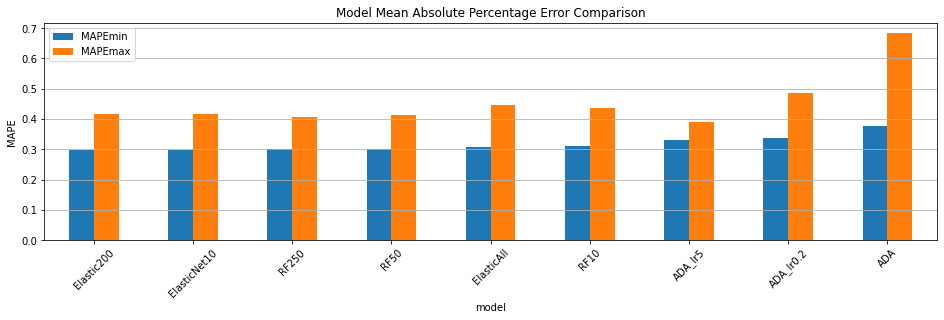

In [9]:
#Plot the accuracies from worst to best going left to right
a = model_scores_hl.drop(index='SGD').sort_values('MAPEmin')
plt.figure(figsize=(16, 6))
a[['MAPEmin', 'MAPEmax']].plot(kind='bar', figsize=(16, 4), label='Best')
plt.ylabel('MAPE')
plt.title('Model Mean Absolute Percentage Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

In [12]:
score_df.sort_values(by='MAPE', inplace=True)
score_df.reset_index(inplace=True, drop=True)
score_df.to_csv(r'Reports/Model_Metrics')

In [13]:
score_df

,model,par,MAPE,MAE,base_estimator,learning_rate,loss,n_estimators,random_state,alpha,...,verbose,average,early_stopping,epsilon,eta0,n_iter_no_change,penalty,power_t,shuffle,validation_fraction
0,Elastic200,28,2.992340e-01,7.375869e-01,NaN,NaN,NaN,NaN,None,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ElasticNet10,28,2.992340e-01,7.375869e-01,NaN,NaN,NaN,NaN,None,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RF250,12,3.015849e-01,9.290594e-01,NaN,NaN,NaN,250.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RF50,28,3.018968e-01,6.939962e-01,NaN,NaN,NaN,50.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RF250,28,3.019587e-01,6.882624e-01,NaN,NaN,NaN,250.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ElasticAll,28,3.063215e-01,7.477842e-01,NaN,NaN,NaN,NaN,None,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RF50,12,3.075381e-01,9.410266e-01,NaN,NaN,NaN,50.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RF10,28,3.106407e-01,7.256431e-01,NaN,NaN,NaN,10.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RF10,12,3.212391e-01,9.728292e-01,NaN,NaN,NaN,10.0,None,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ADA_lr5,28,3.316574e-01,8.878974e-01,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
